In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
fpt = pd.read_csv('FPT.csv')

#1. Xử lý dữ liệu

In [ ]:
fpt

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0
...,...,...,...,...,...,...,...,...
97401,FPT,12/22/2020 14:24,58.20,58.20,58.20,58.20,27470,0
97402,FPT,12/22/2020 14:25,58.20,58.20,58.20,58.20,14820,0
97403,FPT,12/22/2020 14:26,58.20,58.20,58.20,58.20,500,0
97404,FPT,12/22/2020 14:29,58.10,58.10,58.10,58.10,2500,0


In [ ]:
fpt = fpt[['Date/Time', 'Close']]
fpt

,Date/Time,Close
0,12/25/2018 9:15,30.89
1,12/25/2018 9:16,30.81
2,12/25/2018 9:17,30.74
3,12/25/2018 9:18,30.74
4,12/25/2018 9:19,30.74
...,...,...
97401,12/22/2020 14:24,58.20
97402,12/22/2020 14:25,58.20
97403,12/22/2020 14:26,58.20
97404,12/22/2020 14:29,58.10


In [ ]:
# Chuyển dữ liệu từ Time về Date
fpt['Date'] = fpt['Date/Time'].str.split().str[0]
last_records = fpt.groupby('Date').tail(1)
time = last_records['Date/Time'].tolist()
fpt = fpt[fpt['Date/Time'].isin(time)]
fpt = fpt[['Date/Time', 'Close']].copy()
fpt.rename(columns={'Date/Time': 'Time'}, inplace=True)
fpt

<ipython-input-341-1c712fd65419>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpt['Date'] = fpt['Date/Time'].str.split().str[0]


,Time,Close
6,12/25/2018 9:21,30.66
132,12/26/2018 14:46,30.89
266,12/27/2018 14:46,31.19
388,12/28/2018 14:46,31.49
505,1/2/2019 14:46,30.74
...,...,...
96564,12/16/2020 14:46,57.10
96762,12/17/2020 14:46,56.50
96975,12/18/2020 14:46,56.90
97189,12/21/2020 14:46,57.50


In [ ]:
# Xóa time
fpt["Time"] = fpt["Time"].str.replace(r"(\d{4})(\d)", r"\1 \2", regex=True)
fpt["Date"] = fpt["Time"].str.split().str[0]
fpt = fpt[["Date", "Close"]]
fpt

,Date,Close
6,12/25/2018,30.66
132,12/26/2018,30.89
266,12/27/2018,31.19
388,12/28/2018,31.49
505,1/2/2019,30.74
...,...,...
96564,12/16/2020,57.10
96762,12/17/2020,56.50
96975,12/18/2020,56.90
97189,12/21/2020,57.50


In [ ]:
import datetime

def str_to_datetime(s):
  return datetime.datetime.strptime(s, "%m/%d/%Y")

fpt['Date'] = fpt['Date'].apply(str_to_datetime)
fpt['Date']

<ipython-input-343-5fd93553a194>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpt['Date'] = fpt['Date'].apply(str_to_datetime)


,Date
6,2018-12-25
132,2018-12-26
266,2018-12-27
388,2018-12-28
505,2019-01-02
...,...
96564,2020-12-16
96762,2020-12-17
96975,2020-12-18
97189,2020-12-21


In [ ]:
fpt.index = fpt.pop('Date')
fpt

,Close
Date,
2018-12-25,30.66
2018-12-26,30.89
2018-12-27,31.19
2018-12-28,31.49
2019-01-02,30.74
...,...
2020-12-16,57.10
2020-12-17,56.50
2020-12-18,56.90


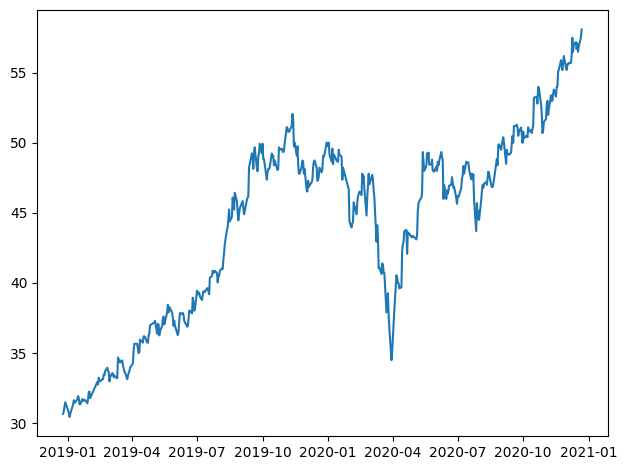

In [ ]:
plt.plot(fpt.index, fpt['Close'])
plt.tight_layout()
plt.show()

#2. Feature Engineering và Huấn luyện Model

In [ ]:
# Splitting Windowed
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_period = dataframe.loc[target_date:target_date+datetime.timedelta(days=10)]
    next_datetime_str = str(next_period.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(fpt, '12/28/2018', '12/22/2020', n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2018-12-28,30.66,30.89,31.19,31.49
1,2019-01-02,30.89,31.19,31.49,30.74
2,2019-01-03,31.19,31.49,30.74,30.44
3,2019-01-04,31.49,30.74,30.44,30.66
4,2019-01-07,30.74,30.44,30.66,31.19
...,...,...,...,...,...
491,2020-12-16,57.00,57.20,56.70,57.10
492,2020-12-17,57.20,56.70,57.10,56.50
493,2020-12-18,56.70,57.10,56.50,56.90
494,2020-12-21,57.10,56.50,56.90,57.50


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((496,), (496, 3, 1), (496,))

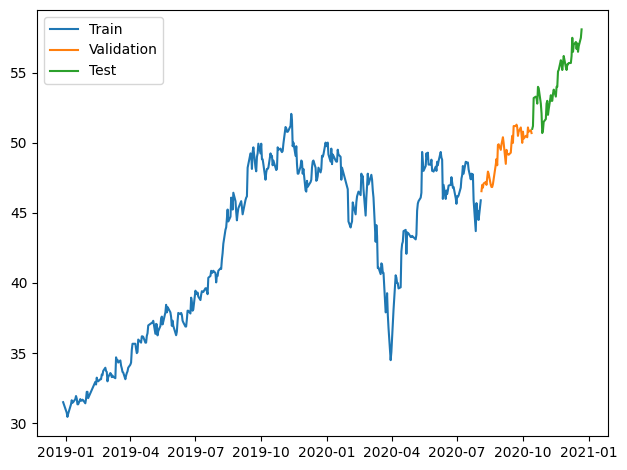

In [ ]:
# Chia dữ liệu
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 1826.9546 - mean_absolute_error: 42.3328 - val_loss: 2277.1443 - val_mean_absolute_error: 47.6953
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1686.6083 - mean_absolute_error: 40.6291 - val_loss: 2145.2256 - val_mean_absolute_error: 46.2914
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1551.0599 - mean_absolute_error: 38.9021 - val_loss: 1935.1127 - val_mean_absolute_error: 43.9627
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1331.0194 - mean_absolute_error: 35.9273 - val_loss: 1567.9448 - val_mean_absolute_error: 39.5654
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 983.1359 - mean_absolute_error: 30.6064 - val_loss: 967.6005 - val_mean_absolute_error: 31.0632
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 482.5534 - mean_absolute_error: 20.8436 - val_loss: 360.6814 - val_mean_absolute_error: 18.9220
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

#3. Đánh giá Model Trực quan hóa

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


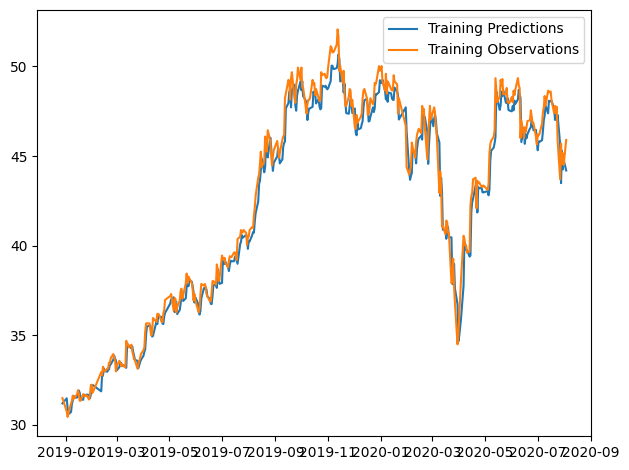

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


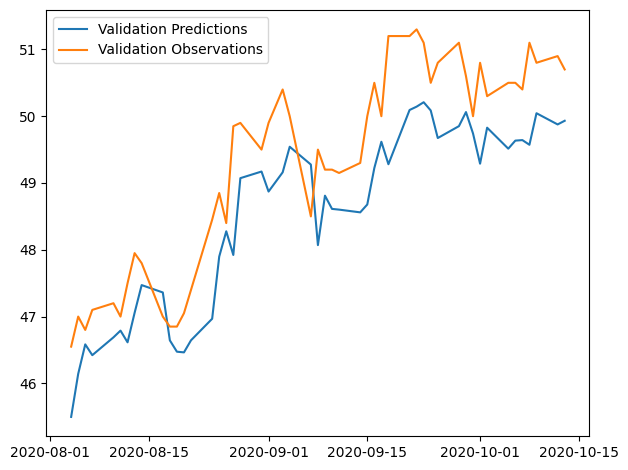

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


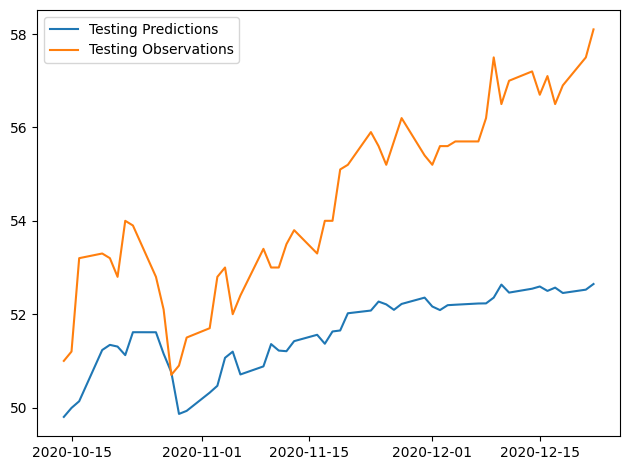

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

plt.tight_layout()
plt.show()

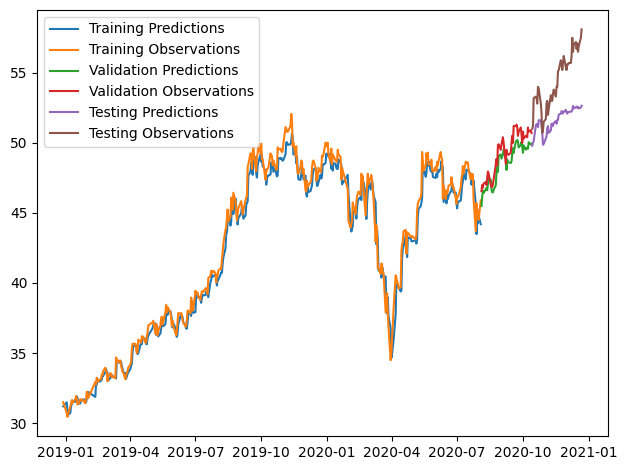

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

plt.tight_layout()
plt.show()

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

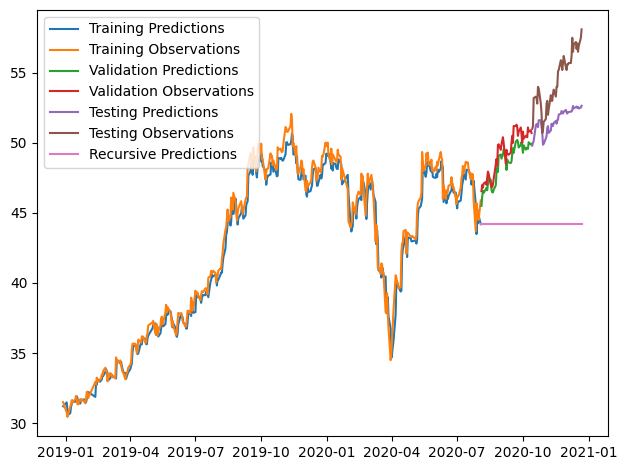

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])

plt.tight_layout()
plt.show()